In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
from qiskit.circuit.library import RZZGate
import networkx as nx
from qiskit.providers.aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
import pandas as pd
import seaborn as sns

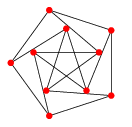

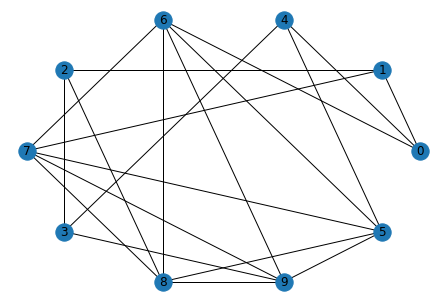

In [2]:
N = 10
graph=[(0,1,1.0),(0,4,1.0),(0,6,2.0),(1,2,1.0),(1,7,1.0),(2,3,3.0),(2,8,1.0),(3,4,2.0),(3,9,1.0),(4,5,2.0),
       (5,6,3.0),(5,7,1.0),(5,8,5.0),(5,9,2.0),(6,7,1.0),(6,8,2.0),(6,9,1.0),(7,8,2.0),(7,9,1.0),(8,9,1.0)] 
G=nx.Graph()
G.add_weighted_edges_from(graph)
pos = nx.circular_layout(G)
nx.draw(G,with_labels=True, pos = pos)

In [3]:
def initialization(circuit):
    for qubit in circuit.qubits:
        circuit.h(qubit)
    return circuit

def cost_unitary_layer(circuit, gamma):
    for edge in graph:
        if edge[0] == 0:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
        
    for edge in graph:
        if edge[0] == 1:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
        
    for edge in graph:
        if edge[0] == 2:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 3:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 4:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 5:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 6:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 7:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
    
    for edge in graph:
        if edge[0] == 8:
            op = RZZGate(gamma*edge[2])
            circuit.append(op, [edge[0],edge[1]])
    circuit.barrier()
        
    return circuit


def mixture_unitary_layer(circuit,alpha):
    for qubit in circuit.qubits:
        circuit.rx(alpha,qubit)
    circuit.barrier()
    return circuit

In [4]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]
    
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold

def first_guess_linear(n_layers, m1 = 0.5, m2 = 0.5):
    theta = np.zeros([2*n_layers])
    for i in range(2*n_layers):
        if i%2 == 0:
            theta[i] = m1*(i+1) / (2*n_layers)
        else:
            theta[i] = m2*(2*n_layers-i) / (2*n_layers)
    return (theta)


def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    c_z, r_z = get_approximation_ratio(z,b)
   

    for key in counts.keys():
        if key != z:
            if counts[key] == counts[z]:
                new_z = key
                c_new, r_new = get_approximation_ratio(new_z,b)
                
    if c_new >= c_z:
        z = new_z
        c_z = c_new
        r_z = r_new
    
    return z, c_z, r_z

def get_decimal_of_key(key):
    decimal = 0
    for i in range(len(key)):
        decimal = decimal + pow(2,i)*int(key[len(key)-1-i])
    return decimal

In [5]:
def anasatz(params):
    n_layers = int(len(params)/2)
    gammas, alphas = create_params(params)
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    circuit = QuantumCircuit(q,c)
    circuit = initialization(circuit)
    for i in range(n_layers):
        circuit = cost_unitary_layer(circuit, gammas[i])
        circuit = mixture_unitary_layer(circuit,alphas[i])
    #circuit.measure(q,c)
    
    
    simulator = StatevectorSimulator()
    result = execute(circuit,simulator).result()
    sv = result.get_statevector(circuit)
    states = Statevector(sv)
    counts = states.probabilities_dict(decimals=3)
    shots = 1000
    for key in counts.keys():
        counts[key] = int(shots*counts[key])
   
    
        
        
    results = counts.keys()
    new_res=[]
    for key in results:
        hold = array_of_key(key)
        for i in range(0,counts[key]):
            new_res.append(hold)
    return circuit,counts,new_res

In [6]:
def cost_function(params):
    circuit,counts,result = anasatz(params)
    total_cost = 0
    for i in range(len(result)):
        for edge in graph:
            total_cost += (A[edge[0]][edge[1]])*(1-2*result[i][edge[0]])*(1-2*result[i][edge[1]]) + (A[edge[1]][edge[0]])*(1-2*result[i][edge[1]])*(1-2*result[i][edge[0]])
    total_cost = total_cost/1000
    #print("Cost: "+str(total_cost))
    return total_cost 

def get_approximation_ratio(z,b):
    c_z = 0
    c_z_max = 0
    z_a =array_of_key(z)
    for edge in graph:
        c_z = c_z + edge[2]*(1/2)*(1-((1-2*z_a[edge[0]])*(1-2*z_a[edge[1]])))
        
    for edge in graph:
        c_z_max = c_z_max + edge[2]*(1/2)*(1-((1-2*b[edge[0]])*(1-2*b[edge[1]])))
        
    app_ratio = c_z / c_z_max
    return c_z,app_ratio

def optimization(method,num_iters,params,n_layers,b):
    print("optimizer: "+str(method))
    out = minimize(cost_function, x0=params, method=method, options={'maxiter':num_iters})
    print(f'Out: {out}')
    c = out.fun
    circuit,counts,result = anasatz(out['x'])
    
    b_freq = 0
    for key in counts.keys():
        if array_of_key(key) == b:
            b_freq = counts[key]
    
    z,c_z,r = get_maximum_z(counts)
    
    maxm = counts[z] / 1000
    decimal_z = get_decimal_of_key(z)
    decimal_b = get_decimal_of_key(b)
    
    
    #c_z,r = get_approximation_ratio(z,b)
    
    
    return (counts,z,decimal_z,c,decimal_b,r, b_freq,c_z,maxm, out['x'])

In [7]:
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
b = xbest_brute


Best solution = [1, 0, 0, 1, 0, 1, 0, 1, 0, 0] cost = 27.0


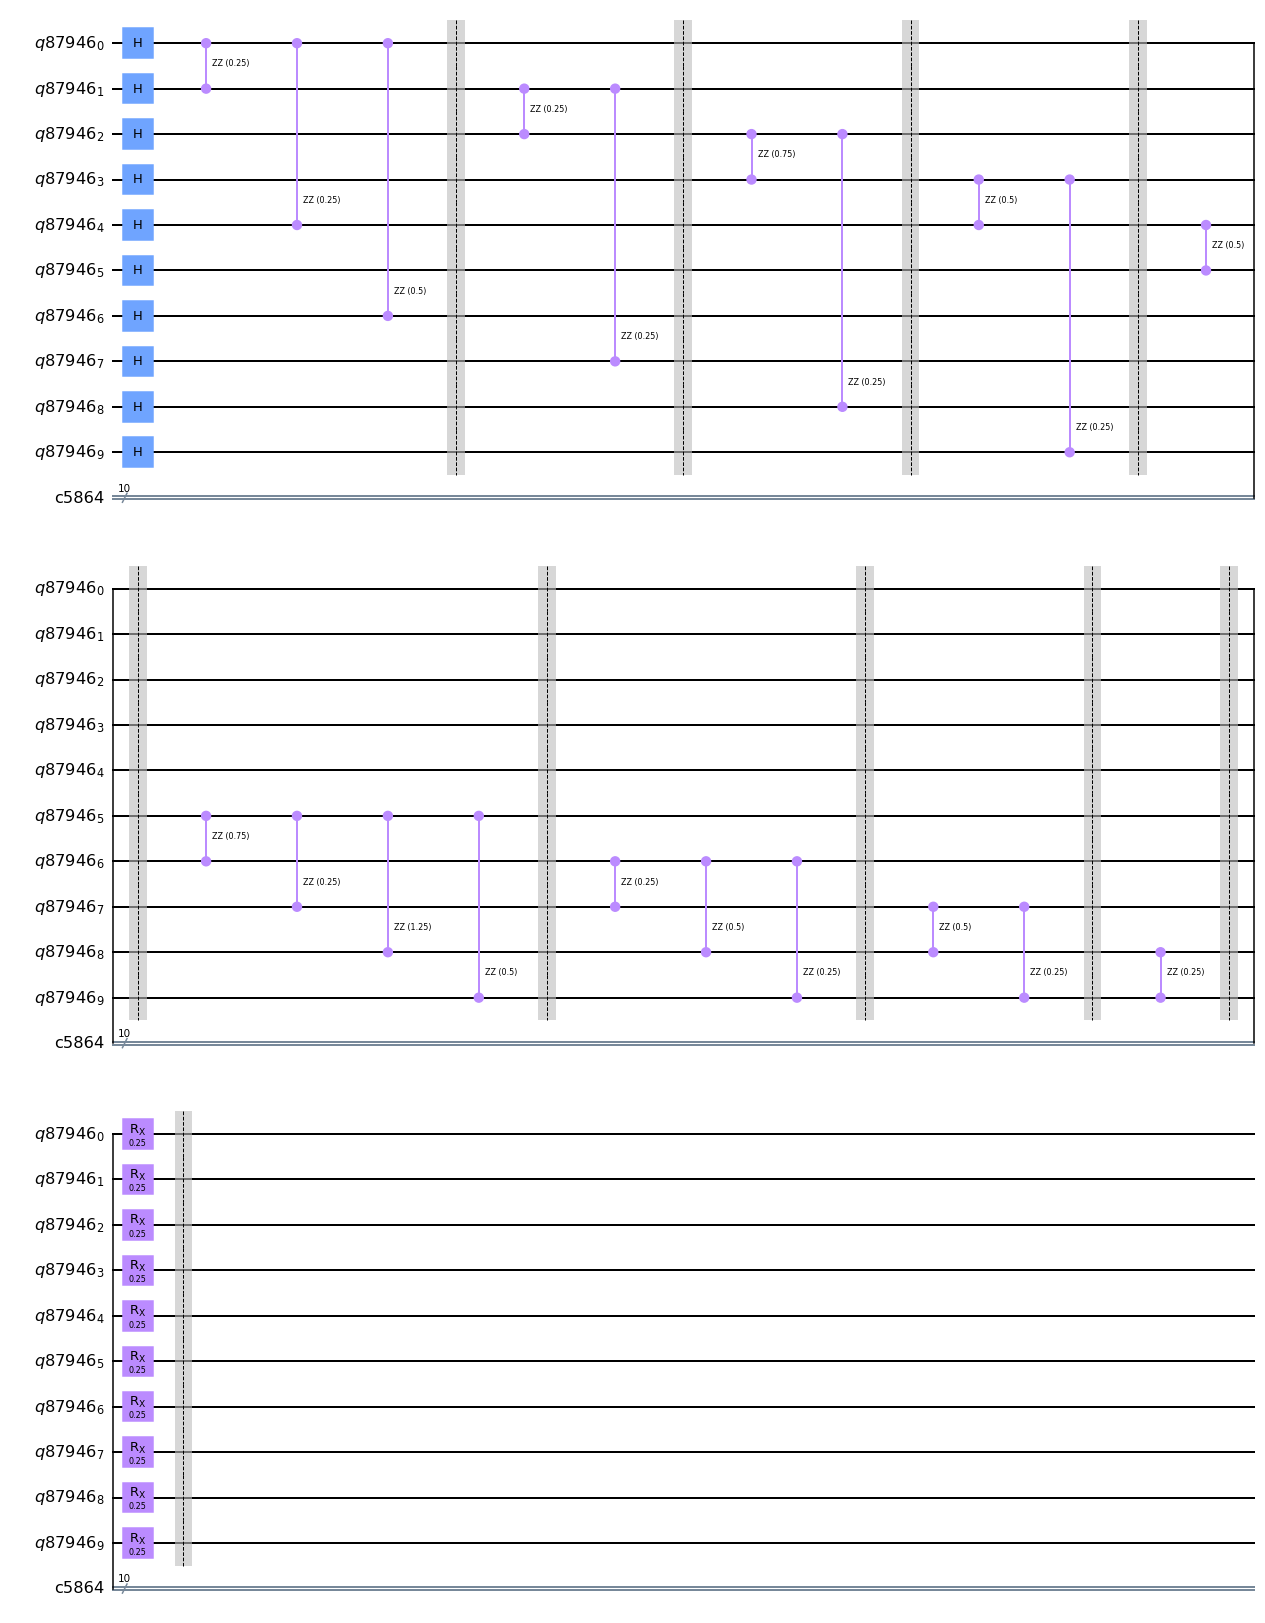

In [40]:
n_layers = 1
params = first_guess_linear(n_layers, m1 = 0.5, m2 = 0.5)
circuit,counts,new_res = anasatz(params)
circuit.draw('mpl')

In [8]:
def plot_histo(data_final, y, optimizer):
    df = pd.DataFrame(np.array(data_final[y].values))
    df.columns = ['a']
    df.index += 1
    df = df.T
    df.columns = ["p_"+str(i) for i in range(1,11)]
    df['optimizer'] = [optimizer]
    print (df)
    solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
    titanic = sns.load_dataset("titanic")
    sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)
    
def plot_line_graph(y):
    #plt.figure(figsize=(10,7))
    x = np.array(range(1,11))
    y1 = df_final_COBYLA[y]
    y2 = df_final_NM[y]
    y3 = df_final_BFGS[y]
    plt.plot(x,y1, "-o")
    plt.plot(x,y2, "-o")
    plt.plot(x,y3, "-o")
    plt.legend(["COBYLA", "Nelder-Mead", "BFGS"], loc ="lower right")
    plt.xlabel("layers")
    plt.ylabel(y)
    plt.show()

In [11]:
data_final = pd.DataFrame(columns=[["inital angles" , "backend" , "optimal angles", "opt obj value","p", "optimizer", "cl ground prob","ground prob", "ground state", "approx ratio"]])
def get_results(method, data_final):
    for p in range(1,11):
        if method == "BFGS":
            init_params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*p)]
            print("random params")
        else:
            init_params = first_guess_linear(p, m1 = 0.5, m2 = 0.5)
        num_iters = 300
        print("optimization for depth :{}".format(p))
        
        backend="Statevector"
        print("initial guess is:" +str(init_params))
    
        opt_results = optimization(method,num_iters,init_params,p,b)
    
        print("z with maximum frequency: "+str(opt_results[1]))
        print("optimal bitstring in decimal: "+str(opt_results[2]))
        print("classical bitstring in decimal: "+str(opt_results[4]))
        print("frequency of classical output in qaoa output: "+str(opt_results[6]))
        print("approximation ratio: "+str(opt_results[5]))
        print("Ground state energy: "+str(opt_results[7]))
        print("Probabilty of ground state energy:"+str(opt_results[8]))
        print("\n")
        optimal_params = opt_results[9]
        
        data = pd.DataFrame([ [init_params], [backend], [optimal_params],[opt_results[3]],
                        [p], [method],[opt_results[6]], [opt_results[8]],  [opt_results[7]], [opt_results[5]]]) 
            
        data = data.T
        data.columns=[["inital angles" , "backend" , "optimal angles", "opt obj value",
                       "p", "optimizer", "cl ground prob","ground prob", "ground state", "approx ratio"]]

        data_final = data_final.append(data)
        
    return data_final

In [12]:
method = "COBYLA"
df_final_COBYLA = get_results(method, data_final)

optimization for depth :1
initial guess is:[0.25 0.25]
optimizer: COBYLA
Out:      fun: -2.928
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([0.93991741, 0.62223442])
z with maximum frequency: 1010010100
optimal bitstring in decimal: 660
classical bitstring in decimal: 596
frequency of classical output in qaoa output: 1
approximation ratio: 0.9629629629629629
Ground state energy: 26.0
Probabilty of ground state energy:0.006


optimization for depth :2
initial guess is:[0.125 0.375 0.375 0.125]
optimizer: COBYLA
Out:      fun: -3.328
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([ 0.99218579,  0.71358072,  1.35163518, -0.26820003])
z with maximum frequency: 1101101111
optimal bitstring in decimal: 879
classical bitstring in decimal: 596
frequency of classical output in qaoa output: 0
approximation ratio: 0.6666666666666666
Ground state energ

In [14]:
method = "Nelder-Mead"
df_final_NM = get_results(method, data_final)

optimization for depth :1
initial guess is:[0.25 0.25]
optimizer: Nelder-Mead
Out:  final_simplex: (array([[0.41953125, 0.046875  ],
       [0.41959915, 0.04682312],
       [0.41959515, 0.04680862]]), array([0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 18
        status: 0
       success: True
             x: array([0.41953125, 0.046875  ])
z with maximum frequency: 1111111111
optimal bitstring in decimal: 1023
classical bitstring in decimal: 596
frequency of classical output in qaoa output: 1
approximation ratio: 0.0
Ground state energy: 0.0
Probabilty of ground state energy:0.001


optimization for depth :2
initial guess is:[0.125 0.375 0.375 0.125]
optimizer: Nelder-Mead
Out:  final_simplex: (array([[-0.26100671,  0.68043605,  1.33308062,  0.16604483],
       [-0.26103188,  0.68037296,  1.33313628,  0.16605148],
       [-0.26104971,  0.68034636,  1.33317428,  0.1660601 ],
       [-0.26102474,  0.68044771

Out:  final_simplex: (array([[ 0.02298528,  0.77651253,  0.13701197,  0.08590084,  0.29829509,
        -0.64542188,  0.46839906,  0.18700767,  0.71528933,  0.03363896,
         0.34752807,  0.14185883,  0.84164329,  0.07474393],
       [ 0.02298651,  0.77647277,  0.13701161,  0.08590774,  0.29829389,
        -0.64542904,  0.46839782,  0.18700816,  0.71528509,  0.03363013,
         0.34751412,  0.14186032,  0.84165308,  0.07474489],
       [ 0.02298638,  0.77647427,  0.13701015,  0.08590827,  0.29829298,
        -0.64543035,  0.46839593,  0.1870081 ,  0.71528259,  0.03362829,
         0.34752229,  0.14186031,  0.84166461,  0.07474513],
       [ 0.02298543,  0.77647279,  0.13701244,  0.0859125 ,  0.29829308,
        -0.64546452,  0.46840095,  0.18701375,  0.71529489,  0.03364371,
         0.34753358,  0.14186045,  0.84165519,  0.07474619],
       [ 0.02298669,  0.77646435,  0.13701192,  0.08589838,  0.2982953 ,
        -0.64544072,  0.46839719,  0.18700863,  0.71528564,  0.03362441,
    

Out:  final_simplex: (array([[-3.43523797e-02,  7.39419410e-01,  1.50038647e-02,
         1.34216304e-01,  2.48241296e-01, -6.47033835e-01,
         4.46687604e-01, -8.79292957e-02,  4.74036406e-01,
         2.43164954e-01,  3.52178024e-01,  3.26549873e-01,
         5.06098615e-01,  2.59577985e-01,  1.23661257e+00,
         1.74029764e-01,  1.27156529e-01, -5.54371802e-04],
       [-3.52685878e-02,  7.67175663e-01,  1.45897820e-02,
         1.26059940e-01,  2.47808957e-01, -6.15767320e-01,
         4.36758471e-01, -1.10650047e-01,  4.73299916e-01,
         2.47453475e-01,  3.67788593e-01,  3.34490106e-01,
         5.14263926e-01,  2.59099587e-01,  1.25196273e+00,
         1.72050170e-01,  1.18734247e-01, -2.55233776e-03],
       [-3.14965341e-02,  7.37957683e-01,  1.82370906e-02,
         1.45825499e-01,  2.43401815e-01, -5.79448744e-01,
         4.30274047e-01, -7.86402285e-02,  4.63073927e-01,
         2.46435744e-01,  3.53140088e-01,  3.23229577e-01,
         5.03616690e-01,  2.5242

In [15]:
method = "BFGS"
df_final_BFGS = get_results(method, data_final)

random params
optimization for depth :1
initial guess is:[-2.63, 0.62]
optimizer: BFGS
Out:       fun: 0.16
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-2.63,  0.62])
z with maximum frequency: 1111110101
optimal bitstring in decimal: 1013
classical bitstring in decimal: 596
frequency of classical output in qaoa output: 0
approximation ratio: 0.5925925925925926
Ground state energy: 16.0
Probabilty of ground state energy:0.009


random params
optimization for depth :2
initial guess is:[0.19, -1.09, -1.07, -0.2]
optimizer: BFGS
Out:       fun: -5.264
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.19, -1.09, -1

Out:       fun: 2.16
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 

r for COBYLA
        p_1       p_2      p_3       p_4       p_5       p_6      p_7  \
a  0.962963  0.666667  0.62963  0.592593  0.666667  0.592593  0.62963   

        p_8       p_9      p_10 optimizer  
a  0.740741  0.740741  0.814815    COBYLA  


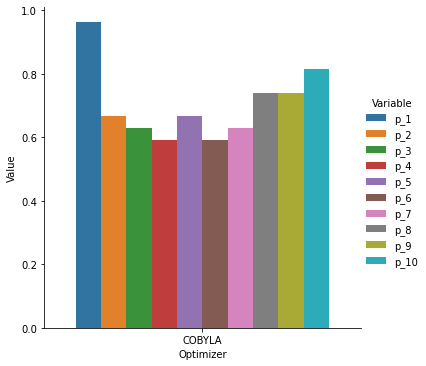

In [16]:
y = "approx ratio"
op = "COBYLA"
print("r for COBYLA")
plot_histo(df_final_COBYLA, y, op)

r for Nelder-Mead 
   p_1       p_2       p_3       p_4       p_5       p_6      p_7      p_8  \
a  0.0  0.851852  0.851852  0.851852  0.851852  0.851852  0.62963  0.62963   

        p_9      p_10    optimizer  
a  0.851852  0.925926  Nelder-Mead  


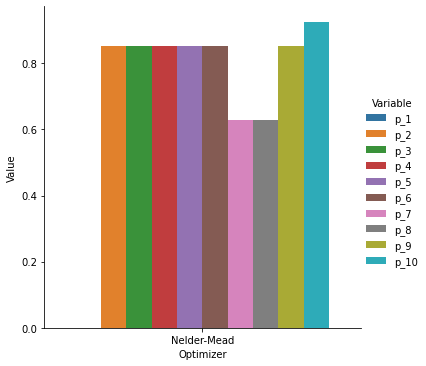

In [17]:
op = "Nelder-Mead"
print("r for Nelder-Mead ")
plot_histo(df_final_NM, y, op)

r for BFGS 
        p_1       p_2       p_3       p_4       p_5      p_6       p_7  \
a  0.592593  0.740741  0.185185  0.111111  0.407407  0.62963  0.814815   

        p_8       p_9      p_10 optimizer  
a  0.666667  0.703704  0.666667      BFGS  


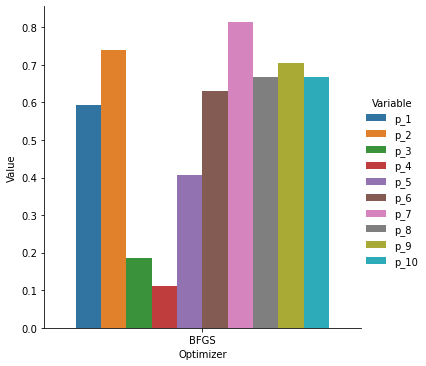

In [18]:
op = "BFGS"
print("r for BFGS ")
plot_histo(df_final_BFGS, y, op)

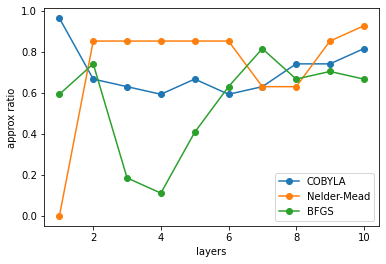

In [34]:
y = "approx ratio"
plot_line_graph(y)

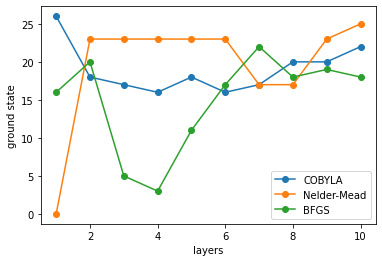

In [35]:
y = "ground state"
plot_line_graph(y)

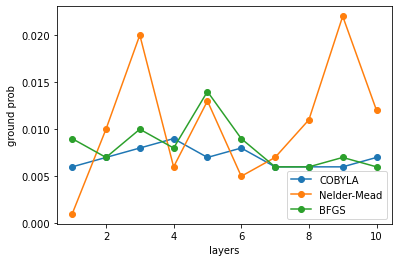

In [36]:
y = "ground prob"
plot_line_graph(y)

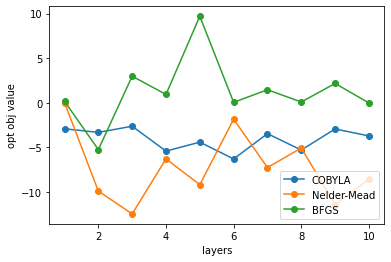

In [37]:
y = "opt obj value"
plot_line_graph(y)

In [38]:
merged = pd.concat([df_final_COBYLA, df_final_NM, df_final_BFGS],ignore_index=True)
merged

,inital angles,backend,optimal angles,opt obj value,p,optimizer,cl ground prob,ground prob,ground state,approx ratio
0,"[0.25, 0.25]",Statevector,"[0.9399174143644735, 0.6222344211682791]",-2.928,1,COBYLA,1,0.006,26.0,0.962963
1,"[0.125, 0.375, 0.375, 0.125]",Statevector,"[0.9921857871770055, 0.713580723364284, 1.3516...",-3.328,2,COBYLA,0,0.007,18.0,0.666667
2,"[0.08333333333333333, 0.4166666666666667, 0.25...",Statevector,"[1.4068753318126566, 0.7788399940858651, 0.693...",-2.64,3,COBYLA,0,0.008,17.0,0.62963
3,"[0.0625, 0.4375, 0.1875, 0.3125, 0.3125, 0.187...",Statevector,"[0.9366602643820842, 0.7723542226348991, 0.387...",-5.432,4,COBYLA,0,0.009,16.0,0.592593
4,"[0.05, 0.45, 0.15, 0.35, 0.25, 0.25, 0.35, 0.1...",Statevector,"[1.0450449418206809, 0.431781251503626, 0.1989...",-4.424,5,COBYLA,1,0.007,18.0,0.666667
5,"[0.041666666666666664, 0.4583333333333333, 0.1...",Statevector,"[1.3539686814464298, 0.6280730849685385, 0.048...",-6.312,6,COBYLA,0,0.008,16.0,0.592593
6,"[0.03571428571428571, 0.4642857142857143, 0.10...",Statevector,"[0.9450955221111658, 0.5073411551769986, 0.176...",-3.472,7,COBYLA,2,0.006,17.0,0.62963
7,"[0.03125, 0.46875, 0.09375, 0.40625, 0.15625, ...",Statevector,"[1.1965853305563539, 0.41079570087983647, -0.0...",-5.312,8,COBYLA,2,0.006,20.0,0.740741
8,"[0.027777777777777776, 0.4722222222222222, 0.0...",Statevector,"[0.9818242424755254, 0.4027695074341306, -0.17...",-2.944,9,COBYLA,0,0.006,20.0,0.740741
9,"[0.025, 0.475, 0.075, 0.425, 0.125, 0.375, 0.1...",Statevector,"[1.0085628744190527, 0.48815597764563146, 0.02...",-3.728,10,COBYLA,1,0.007,22.0,0.814815


In [39]:
merged.to_csv(r'E:\Repo1\QAOA3\10_nodes_2.csv')